<a href="https://colab.research.google.com/github/ekaterinatao/hackathon_books_text_classification/blob/main/code_cru_roberta_ru_v2_sasha_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Установка зависимостей

In [1]:
!pip install datasets evaluate seqeval -qqq
!pip install accelerate -U -qqq
!pip install wandb -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm_notebook

import torch
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import EvalPrediction
from transformers import TrainingArguments, Trainer
from transformers import pipeline
import evaluate

import warnings
warnings.filterwarnings("ignore")

### Скачивание датасета

In [3]:
url = 'https://raw.githubusercontent.com/ekaterinatao/hackathon_books_text_classification/main/data/book_fb2_dataset.csv'
data_raw = pd.read_csv(
    url, sep=',', header=0, names=['text', 'tag']
)
data_raw.head(5)

,text,tag
0,"1.0 — распознавание, вычитка, верстка — sklart...",p
1,Авторы книги считают своим долгом выразить глу...,p
2,Авторы и издатели благодарны руководителям орг...,p
3,В плеяде выдающихся организаторов производства...,p
4,"Он прожил свою жизнь в XX веке, но и в XXI век...",p


In [ ]:
data_raw.shape

(53109, 2)

In [ ]:
data_raw['tag'].nunique()

11

In [ ]:
data_raw['tag'].value_counts()

p             46266
title          3580
subtitle       1286
poem            895
cite            490
epigraph        273
author          139
annotation       96
book-title       64
publisher        15
keywords          5
Name: tag, dtype: int64

In [4]:
# удаление минорных классов
data_new = data_raw[data_raw['tag'] !='publisher']
data_new = data_new[data_new['tag'] !='keywords']

In [5]:
data_no_p = data_new[data_new['tag'] !='p']

In [6]:
data_p = data_new[data_new['tag'] =='p']

In [7]:
# уменьшение размера самого большого класса
data_p_selected = data_p.sample(n=4000)

In [8]:
frames = [data_p_selected, data_no_p]
data_raw = pd.concat(frames)
data_raw

,text,tag
6917,— Что колонна? — не выдержал Стефан.,p
845,Умер 20 октября 1996 года. Похоронен на Ступин...,p
23683,"— Разумеется, — спокойно ответил Бранделиус. —...",p
23822,"Не переломилась, не прогнулась, не стала сколь...",p
18593,Ты игрок? Любишь щекотать нервы? Или ты идейны...,p
...,...,...
53104,"Павел Анатольевич Судоплатов, по мнению истори...",subtitle
53105,Сергей Михайлович Шпигельглас лично курировал ...,subtitle
53106,"Владимир Александрович Крючков, председатель К...",subtitle
53107,"Виталий Александрович Сырокомский, главный ред...",subtitle


In [ ]:
data_raw['tag'].value_counts()

p             4000
title         3580
subtitle      1286
poem           895
cite           490
epigraph       273
author         139
annotation      96
book-title      64
Name: tag, dtype: int64

In [9]:
le = LabelEncoder()
data_raw['labels'] = le.fit_transform(data_raw['tag'])

In [10]:
ind_to_label = {int(i):label for i, label in zip(data_raw['labels'], data_raw['tag'])}
labels_dict = sorted(list(ind_to_label.items()), key=lambda x: x[0])
labels_dict

[(0, 'annotation'),
 (1, 'author'),
 (2, 'book-title'),
 (3, 'cite'),
 (4, 'epigraph'),
 (5, 'p'),
 (6, 'poem'),
 (7, 'subtitle'),
 (8, 'title')]

### Подготовка данных к загрузке в DataLoader

In [ ]:
train_text, val_text = train_test_split(
    data_raw, test_size=0.3, stratify=data_raw['tag'], random_state=42
)
print(f'train: {len(train_text)}, val: {len(val_text)}')

train: 7576, val: 3247


In [ ]:
train_text['tag'].value_counts(normalize=True) * 100

p             36.958817
title         33.078141
subtitle      11.879620
poem           8.276135
cite           4.527455
epigraph       2.521119
author         1.280359
annotation     0.884372
book-title     0.593981
Name: tag, dtype: float64

In [ ]:
val_text['tag'].value_counts(normalize=True) * 100

p             36.957191
title         33.076686
subtitle      11.887897
poem           8.253773
cite           4.527256
epigraph       2.525408
author         1.293502
annotation     0.893132
book-title     0.585156
Name: tag, dtype: float64

In [ ]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_text),
    'valid': Dataset.from_pandas(val_text)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__'],
        num_rows: 7576
    })
    valid: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__'],
        num_rows: 3247
    })
})

___
### Токенизация с помощью модели [RoBERTa](https://huggingface.co/DeepPavlov/xlm-roberta-large-en-ru-mnli)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def preprocess_data(examples):
    encoding = tokenizer(examples['text'], truncation=True, max_length=512)
    return encoding

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/xlm-roberta-large-en-ru-mnli")

tokenizer_config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/944k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True)
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/7576 [00:00<?, ? examples/s]

Map:   0%|          | 0/3247 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 7576
    })
    valid: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 3247
    })
})

In [ ]:
df = encoded_dataset['train']
full_dataframe = pd.DataFrame({
    'id': df['__index_level_0__'],
    'text': df['text'],
    'tag': df['tag'],
    'labels': df['labels'],
    'input_ids': df['input_ids'],
    'attention_mask': df['attention_mask']
})

In [ ]:
full_dataframe[full_dataframe['tag']=='book-title']

,id,text,tag,labels,input_ids,attention_mask
305,16943,Полководцы Святой Руси,book-title,2,"[tensor(0), tensor(9159), tensor(1222), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
402,53022,Пиросмани,book-title,2,"[tensor(0), tensor(6206), tensor(6949), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
687,43711,Paganini. La vita l I'opera,book-title,2,"[tensor(0), tensor(3879), tensor(66), tensor(9...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1354,17086,Плотин. Единое: творящая сила Созерцания,book-title,2,"[tensor(0), tensor(20348), tensor(3341), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1400,3673,Петр Смородин,book-title,2,"[tensor(0), tensor(16510), tensor(19016), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1441,22877,Пришвин,book-title,2,"[tensor(0), tensor(1422), tensor(736), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1711,21618,Picasso His Life and Work,book-title,2,"[tensor(0), tensor(30567), tensor(6774), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1730,14034,Петрашевский,book-title,2,"[tensor(0), tensor(21519), tensor(11564), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1732,31669,Аносов,book-title,2,"[tensor(0), tensor(536), tensor(5928), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2002,31768,Поль Гоген,book-title,2,"[tensor(0), tensor(12803), tensor(4849), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


### Обучение модели

In [ ]:
ACCURACY = evaluate.load("accuracy")
F1 = evaluate.load("f1")
MCC = evaluate.load("matthews_correlation")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions
    preds = np.argmax(preds, axis=1)

    acc_result = ACCURACY.compute(predictions=preds, references=p.label_ids)
    f1_result = F1.compute(predictions=preds, references=p.label_ids, average='weighted')
    mcc_result = MCC.compute(predictions=preds, references=p.label_ids)
    result = {
        "accuracy": acc_result["accuracy"],
        "f1-score": f1_result["f1"],
        "mcc": mcc_result["matthews_correlation"]
    }

    return result

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
os.environ["WANDB_PROJECT"]="books_text_class_roBERTa_ru_base"

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/xlm-roberta-large-en-ru-mnli", num_labels=11, ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/xlm-roberta-large-en-ru-mnli and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([11, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/Hackaton/output',
    learning_rate=1e-05,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    #weight_decay=0.0001,
    evaluation_strategy="epoch",
    push_to_hub=True,
    #report_to="wandb",
    run_name="batch_4_run",
    save_strategy="no",
    group_by_length=True,
    warmup_ratio=0.1,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Mcc
1,0.399400,0.393144,0.881429,0.862185,0.839741
2,0.265900,0.287168,0.959039,0.955958,0.943991
3,0.226200,0.252783,0.959963,0.956594,0.945251
4,0.151400,0.246521,0.956883,0.956727,0.941288
5,0.131900,0.280788,0.962119,0.961652,0.948210
6,0.064900,0.265596,0.966123,0.965568,0.953593
7,0.051300,0.271583,0.966431,0.966161,0.954081
8,0.015900,0.294840,0.966739,0.966463,0.954536
9,0.012100,0.297162,0.966431,0.966249,0.954149
10,0.009000,0.300587,0.967662,0.967420,0.955817


TrainOutput(global_step=18940, training_loss=0.15074122136472523, metrics={'train_runtime': 5948.5909, 'train_samples_per_second': 12.736, 'train_steps_per_second': 3.184, 'total_flos': 6997226255931984.0, 'train_loss': 0.15074122136472523, 'epoch': 10.0})

In [ ]:
wandb.finish()

eval/accuracy,▁▇▇▇██████
eval/f1-score,▁▇▇▇██████
eval/loss,█▃▁▁▃▂▂▃▃▄
eval/mcc,▁▇▇▇██████
eval/runtime,▁▄▂▁█▅▃▆▇▃
eval/samples_per_second,█▅▇█▁▄▆▃▂▆
eval/steps_per_second,█▅▇█▁▄▆▃▂▆
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▄█▂▂▃▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/loss,█▅▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
trainer.save_model('/content/drive/MyDrive/Colab Notebooks/Hackaton/output')

events.out.tfevents.1702842813.12f0ce24703b.264.0:   0%|          | 0.00/5.36k [00:00<?, ?B/s]

events.out.tfevents.1702843928.12f0ce24703b.264.1:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Upload 9 LFS files:   0%|          | 0/9 [00:00<?, ?it/s]

events.out.tfevents.1702843947.12f0ce24703b.264.2:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

events.out.tfevents.1702844253.2774340f9fb3.157.0:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

events.out.tfevents.1702844282.2774340f9fb3.157.1:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

events.out.tfevents.1702844301.2774340f9fb3.157.2:   0%|          | 0.00/5.20k [00:00<?, ?B/s]

events.out.tfevents.1702844670.2774340f9fb3.157.3:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

### Загрузка сохраненной модели

In [ ]:
checkpoint = 'beneor/output'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=11, ignore_mismatched_sizes=True
)

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

In [ ]:
preds = trainer.predict(encoded_dataset["valid"])
preds2 = preds.predictions
predicted_labels = np.argmax(preds2, axis=1)
print(predicted_labels)

[5 5 8 ... 8 5 3]


In [ ]:
preds.metrics

{'test_loss': 0.26338908076286316,
 'test_accuracy': 0.9710502001847859,
 'test_f1-score': 0.9706845940614982,
 'test_mcc': 0.9603906784760734,
 'test_runtime': 37.4636,
 'test_samples_per_second': 86.671,
 'test_steps_per_second': 21.674}

In [ ]:
true_labels = encoded_dataset['valid']['labels'].tolist()
print(true_labels)

[5, 5, 8, 8, 5, 5, 7, 8, 6, 8, 8, 4, 8, 5, 8, 3, 8, 6, 8, 5, 5, 5, 8, 8, 8, 8, 8, 5, 5, 4, 8, 5, 7, 7, 5, 5, 7, 5, 7, 8, 8, 7, 5, 7, 8, 4, 7, 5, 8, 5, 8, 7, 6, 5, 8, 5, 5, 5, 6, 5, 5, 3, 8, 8, 8, 6, 8, 5, 7, 8, 7, 1, 5, 6, 7, 6, 3, 3, 7, 7, 5, 5, 8, 8, 7, 5, 8, 8, 6, 5, 7, 5, 8, 8, 8, 5, 5, 6, 8, 7, 3, 6, 8, 7, 8, 8, 2, 8, 8, 7, 8, 5, 8, 5, 5, 5, 3, 6, 5, 5, 5, 5, 5, 8, 3, 3, 8, 5, 6, 8, 5, 3, 8, 7, 5, 7, 8, 5, 8, 5, 7, 5, 8, 7, 5, 1, 5, 8, 4, 7, 8, 8, 8, 5, 8, 8, 5, 3, 7, 3, 7, 8, 5, 8, 1, 5, 7, 8, 8, 5, 6, 0, 7, 7, 8, 5, 5, 7, 8, 5, 3, 5, 5, 5, 8, 8, 5, 5, 5, 7, 5, 5, 5, 7, 8, 5, 5, 5, 8, 7, 8, 8, 8, 5, 3, 5, 8, 5, 6, 5, 5, 3, 5, 8, 8, 3, 8, 6, 5, 4, 8, 5, 8, 4, 8, 8, 8, 7, 8, 8, 7, 7, 5, 8, 7, 0, 8, 5, 5, 8, 5, 5, 8, 8, 8, 7, 5, 8, 8, 7, 7, 7, 5, 6, 8, 5, 5, 7, 5, 8, 5, 8, 3, 8, 8, 5, 8, 5, 8, 5, 8, 5, 8, 8, 5, 5, 2, 5, 0, 8, 8, 8, 5, 6, 5, 5, 7, 5, 5, 7, 8, 5, 6, 6, 7, 8, 8, 5, 5, 0, 8, 8, 5, 5, 7, 8, 5, 6, 5, 5, 8, 8, 8, 5, 5, 8, 8, 8, 8, 5, 6, 8, 8, 5, 7, 7, 0, 5, 8, 8, 6, 8, 8, 

### Оценка качества на тестовой выборке

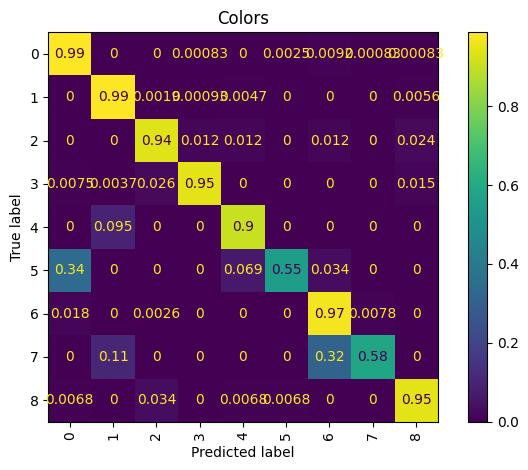

In [ ]:
cn_matrix = confusion_matrix(
    y_true = true_labels,
    y_pred = predicted_labels,
    labels = list(map(int, labels_dict.values())),
    normalize="true",
)
ConfusionMatrixDisplay(cn_matrix).plot(
    include_values=True, xticks_rotation="vertical"
)
plt.title("Colors")
plt.tight_layout()
plt.show()

In [11]:
labels_dict

[(0, 'annotation'),
 (1, 'author'),
 (2, 'book-title'),
 (3, 'cite'),
 (4, 'epigraph'),
 (5, 'p'),
 (6, 'poem'),
 (7, 'subtitle'),
 (8, 'title')]

### Инференс на книге в формате `word`

In [ ]:
!pip install python-docx -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from docx import Document
import sys

In [ ]:
def read_docx(file_path):
    doc = Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return full_text

def create_dataframe(formatted_text):
    # Создаем DataFrame
    df = pd.DataFrame(formatted_text, columns=['text'])
    return df

# PATH to file docx
input_file_path = '/content/Мужские_души_в_ПО_после_первой_читки (2).docx'
# Обрабатываем docx файл
formatted_text = read_docx(input_file_path)

# Создаем DataFrame из обработанных данных
df = create_dataframe(formatted_text)

In [ ]:
dataset_book = Dataset.from_pandas(df)
dataset_book

Dataset({
    features: ['text'],
    num_rows: 1306
})

In [ ]:
encoded_book = dataset_book.map(preprocess_data, batched=True)
encoded_book.set_format("torch")
encoded_book

Map:   0%|          | 0/1306 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 1306
})

In [ ]:
preds_book = trainer.predict(encoded_book)
preds2_book = preds_book.predictions
predicted_labels_book = np.argmax(preds2_book, axis=1)

In [ ]:
predicted_labels_book

array([7, 7, 7, ..., 5, 5, 5])

In [ ]:
df['labels'] = predicted_labels_book

In [ ]:
df['tags'] = df['labels'].apply(lambda x: ind_to_label[x])

In [ ]:
df

,text,labels,tags
0,БЬОРН ЗЮФКЕ,7,subtitle
1,,7,subtitle
2,Мужские души,7,subtitle
3,Психологический путеводитель по хрупкому миру ...,7,subtitle
4,"Все фрагменты, выделенные желтым, - это полосн...",3,cite
...,...,...,...
1301,Шизоидное расстройство личности характеризуетс...,0,annotation
1302,"Эмпатия — это термин, используемый для описани...",5,p
1303,"Эксгибиционизм — это сексуальное отклонение, к...",5,p
1304,Экстернальная атрибуция. Термин «атрибуция» оп...,5,p


In [ ]:
df.to_csv('book_result.csv', index=False)